In [1]:
# For data analysis
import numpy as np
import pandas as pd

#For navigating directories
import os

#For graphing
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#Image processing
from skimage.measure import regionprops,regionprops_table, label
from skimage.morphology import convex_hull_object,area_opening,binary_opening,disk,reconstruction
from skimage.segmentation import expand_labels,watershed
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt, fourier_gaussian
from scipy.signal import convolve2d,fftconvolve
import numpy.fft as fft

#Statistics
from scipy.stats import gaussian_kde
from skimage.color import label2rgb


def fgauss(img,sigma,pad=True,pad_width=50):
    if pad:
        img = np.pad(img.copy(),pad_width=pad_width,mode="edge")
    input_ = fft.fft2(img)
    result = fourier_gaussian(input_, sigma=sigma)
    result = fft.ifft2(result)
    img = result.real
    if pad:
        img = img[pad_width:-pad_width,pad_width:-pad_width]
    return img


def sgolay2d ( z, window_size, order):
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0

    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')

    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2

    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]

    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])

    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band )
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z

    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band )

    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band )
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band )
    m = np.linalg.pinv(A)[0].reshape((window_size, -1))
    new_img = fftconvolve(Z, m, mode='valid')
    return new_img

def gaussSNIP(img,niter=4,radius=1,sigma_factor=2,pad_width=50):
    img = np.pad(img.copy(),pad_width=pad_width,mode="edge")
    for i in range(niter):
        blur = fgauss(img,radius*(sigma_factor*i+1),pad=False)
        img[img>blur] = blur[img>blur]
    background = img[pad_width:-pad_width,pad_width:-pad_width]
    return background

def cycleSNIP(img,niter=4,radius=1,sigma_factor=2,pad_width=50):
    bgcorr = img.copy()
    background =np.zeros(img.shape)
    for i in np.arange(1,niter+1)[::-1]:
        temp_background = gaussSNIP(bgcorr,niter=i,radius=radius,
                                    sigma_factor=sigma_factor,pad_width=pad_width)
        background = background + temp_background
        bgcorr =  bgcorr - temp_background
    return background

def find_radius(img_raw,img_fit):
    
    img_res = fgauss(np.abs(img_raw-img_fit),2.5)
    img_bgcorr = img_fit - gaussSNIP(img_fit,niter=4,radius=1,sigma_factor=2,pad_width=50)
    img_binary = img_bgcorr - 1*img_res
    img_binary[img_binary<0] = 0
    img_binary[img_binary>0] = 1

    img_label = label(img_binary)
    img_rprops = pd.DataFrame(regionprops_table(img_label,img_bgcorr,
                                                properties=('area','convex_area',
                                                            'minor_axis_length','mean_intensity')))
    img_rprops["intensity"] = img_rprops.mean_intensity*img_rprops.area
    int_cutoff = img_rprops.intensity[img_rprops.area==1].max()
    img_rprops = img_rprops.loc[img_rprops.mean_intensity>int_cutoff,:]
    areas = np.sort(img_rprops.area.values)
    img_radius = np.sqrt(areas).mean()/2
    
    return img_radius

class SIA:
    def __init__(self,img_raw,center_only=False,predefect=None,find_defect=True):
        img_fit = sgolay2d(img_raw.astype(float), window_size=3, order=0)
        img_radius = find_radius(img_raw,img_fit)
        img_res = fgauss(np.abs(img_raw-img_fit),2.5*img_radius)

 
        img_bg = cycleSNIP(img_fit,niter=4,radius=img_radius,sigma_factor=2,pad_width=50)
        #gaussSNIP(img_fit,niter=1,radius=img_radius,sigma_factor=2,pad_width=50)
        #
        
        img_bgcorr = img_fit - img_bg
        img_bgcorr[img_bgcorr<0] = 0

        seed = img_res.copy()
        seed[1:-1, 1:-1] = 0

        seed[img_bgcorr<seed] = img_bgcorr[img_bgcorr<seed]
        img_bgcorr = img_bgcorr - reconstruction(seed,img_bgcorr)
        img_bgcorr[img_bgcorr<0] = 0

        img_binary = img_bgcorr - img_res
        
        
        img_binary[img_binary<0] = 0
        img_binary[img_binary>0] = 1

        img_label = label(img_binary)
        img_rprops = pd.DataFrame(regionprops_table(label_image = img_label,
                                                     intensity_image = img_bgcorr,
                                                     properties=('label','area','convex_area',
                                                                 'mean_intensity','max_intensity',
                                                                 'major_axis_length',
                                                                 'minor_axis_length',
                                                                 'weighted_centroid')))


        img_rprops["intensity"] = img_rprops.mean_intensity*img_rprops.area
        img_rprops["logmean_intensity"] = np.log10(img_rprops.mean_intensity)
        img_rprops["log_intensity"] = np.log10(img_rprops.intensity)
        int_cutoff = img_rprops.intensity[img_rprops.area==1].mean()
        int_cutoff = int_cutoff + 2.5*img_rprops.intensity[img_rprops.area==1].std()
        img_rprops["axis_ratio"] = img_rprops.major_axis_length/img_rprops.minor_axis_length
        img_rprops["area_ratio"] = img_rprops.convex_area/img_rprops.area
        img_rprops = img_rprops.loc[img_rprops.mean_intensity>int_cutoff,:]
        img_binary[~np.isin(img_label,img_rprops.label)] = 0



        defect_bool = (((img_rprops.axis_ratio > 4) |
                        (img_rprops.area_ratio > 1.10)) &
                        (img_rprops.area > ((2.5*img_radius)**2)))

        defect_labels = img_rprops.loc[defect_bool,:]
        defect_radius = np.sqrt(defect_labels.area).mean()/5
        defect_labels = defect_labels.loc[:,"label"].values

        img_rprops = img_rprops.loc[~defect_bool,:]


        img_defect = img_label.copy().astype(int)

        if (defect_labels.size>0) and find_defect:
            img_defect[~np.isin(img_label,defect_labels)] = 0
            img_defect = expand_labels(img_defect, distance=defect_radius)
            img_defect = convex_hull_object(img_defect).astype(int)

        if img_defect[img_defect!=img_label].size==0:
            img_defect[:,:] = 0

        if center_only:
            center = regionprops(img_binary.astype(int))[0].centroid
            rmsd = np.sqrt((((img_rprops["weighted_centroid-0"].values-center[0])**2
                             +((img_rprops["weighted_centroid-1"].values-center[1])**2)).mean()))
            nrows, ncols = img_raw.shape
            row, col = np.ogrid[:nrows, :ncols]
            center_disk_img = ((row - center[0])**2 + (col - center[1])**2 <= (rmsd)**2)
            img_defect[~center_disk_img] = 1

        if predefect is not None:
            img_defect = img_defect + predefect
            img_defect[img_defect>0] = 1
            img_defect = img_defect.astype(int)

        if img_defect[img_defect!=img_label].size==0:
            img_defect[:,:] = 0


        img_binary[~np.isin(img_label,img_rprops.label)] = 0
        img_binary[img_defect==1] = 0

        distance = distance_transform_edt(img_binary)
        coords = peak_local_max(img_binary*img_bgcorr,min_distance=int(np.round(img_radius/1.25,0)))
        markers = np.zeros(distance.shape, dtype=bool)
        markers[tuple(coords.T)] = True
        markers = label(markers)
        img_label = watershed(-distance, markers, mask=img_bgcorr)

        img_bgcorr = img_raw - gaussSNIP(img_fit,niter=2,radius=img_radius,sigma_factor=2,pad_width=50)
        #img_bgcorr[img_bgcorr<0] = 0
        img_bgcorr[img_bgcorr<1] = 1 #img_bgcorr[img_bgcorr>0].min()

        img_rprops = pd.DataFrame(regionprops_table(label_image = img_label,
                                                     intensity_image = img_bgcorr,
                                                     properties=('label','area','convex_area',
                                                                 'mean_intensity','max_intensity',
                                                                 'major_axis_length',
                                                                 'minor_axis_length',
                                                                 'weighted_centroid')))

        img_rprops = img_rprops.rename(columns={"weighted_centroid-0": "coordX",
                                                "weighted_centroid-1": "coordY"})
        
        res_rprops = pd.DataFrame(regionprops_table(label_image = img_label,
                                                     intensity_image = img_res,
                                                     properties=('label','mean_intensity')))
        
        
        img_rprops["intensity"] = img_rprops.mean_intensity*img_rprops.area
        img_rprops["logmean_intensity"] = np.log10(img_rprops.mean_intensity)
        img_rprops["log_intensity"] = np.log10(img_rprops.intensity)
        img_rprops["mean_noise"] = res_rprops.mean_intensity
        img_rprops["noise"] = img_rprops.mean_noise*img_rprops.area
        img_rprops["snr"] = img_rprops.intensity/img_rprops.noise
        img_rprops["log_snr"] = np.log10(img_rprops.snr)
        

        img_rprops = img_rprops.loc[:,['label','area',
                                       'coordX','coordY','mean_intensity','mean_noise',
                                       'intensity','logmean_intensity','log_intensity',
                                       'noise','snr','log_snr']]
        
        self.img_label = img_label
        self.img_bgcorr = img_bgcorr
        self.img_res = img_res
        self.img_rprops = img_rprops
        self.img_radius = img_radius
        self.img_defect = img_defect



class DIA:
    def __init__(self,mask_raw,target_raw,center_only=False):
    
        sia = SIA(target_raw,center_only=center_only,predefect=None,find_defect=True)
        target_label = sia.img_label
        target_bgcorr = sia.img_bgcorr
        target_res = sia.img_res
        target_rprops = sia.img_rprops
        target_radius = sia.img_radius
        target_defect = sia.img_defect
        

        target_binary = target_label.copy()
        target_binary[target_binary>0] = 1

        sia = SIA(mask_raw,center_only=False,predefect=target_defect,find_defect=False)
        mask_label = sia.img_label
        mask_bgcorr = sia.img_bgcorr
        mask_rprops = sia.img_rprops
        mask_radius = sia.img_radius
        mask_defect = sia.img_defect

        mask_binary = mask_label.copy()
        mask_binary[mask_binary>0] = 1

        mask_expanded = expand_labels(mask_label, distance=mask_radius)
        mask_expbin = mask_expanded.copy()
        mask_expbin[mask_expbin>0] = 1

        positives = np.isin(mask_rprops.label.values,np.unique(target_binary*mask_expanded))

        mask_rprops["positive"] = positives

        overlap_label = (target_binary*mask_expanded).astype(int)
        measure_label = overlap_label.copy()
        miss_labels = mask_rprops.label[~np.isin(mask_rprops.label,np.unique(overlap_label))].values
        measure_label[np.isin(mask_label,miss_labels)] = mask_label[np.isin(mask_label,miss_labels)]

        overlap_data = pd.DataFrame(regionprops_table(label_image = measure_label,
                                                 intensity_image = target_bgcorr,
                                                 properties=('label','weighted_centroid',
                                                             'area','mean_intensity')))
        overlap_data = overlap_data.rename(columns={"weighted_centroid-0": "coordX",
                                                    "weighted_centroid-1": "coordY"})
        
        res_data = pd.DataFrame(regionprops_table(label_image = measure_label,
                                                 intensity_image = target_res,
                                                 properties=('label','mean_intensity')))
        
        
        overlap_data["intensity"] = overlap_data.area*overlap_data.mean_intensity
        overlap_data["logmean_intensity"] = np.log10(overlap_data.mean_intensity)
        overlap_data["log_intensity"] = np.log10(overlap_data.intensity)
        overlap_data["mean_noise"] = res_data.mean_intensity
        overlap_data["noise"] = overlap_data.mean_noise*overlap_data.area
        overlap_data["snr"] = overlap_data.intensity/overlap_data.noise
        overlap_data["log_snr"] = np.log10(overlap_data.snr)
        
        
        data = mask_rprops.loc[:,list(overlap_data.columns.values)]
        data.columns = 'mask_'+data.columns.values
        overlap_data.columns = 'biomarker_'+overlap_data.columns.values
        
        data = pd.concat([data,overlap_data],axis=1)
        data["positive"] = positives
        data.columns
        
        fp = data.positive[data.positive].size/data.positive.size

        fdr = (target_binary[target_binary>0].size
               *mask_expanded[mask_expanded>0].size
               /(target_defect[target_defect==0].size**2))

        results = pd.DataFrame(np.array([target_rprops.shape[0],data.shape[0],
                                         fp,fdr,mask_radius,target_radius])).T
        results.columns = ['n_biomarkers','n_exosomes','Fp','FDR','mask_radius','target_radius']
        
        self.mask_label = mask_label
        self.mask_bgcorr = mask_bgcorr
        self.target_label = target_label
        self.target_bgcorr = target_bgcorr
        self.overlap_label = overlap_label
        self.mask_defect = mask_defect
        self.data = data
        self.results = results

In [2]:
%%time
target_raw = plt.imread("/Users/gallops/Documents/SEDIA_process/Images_for_Caleb/3_11_2021/Exosomes/CD44_AuNP/DF01.tif").astype(float)
mask_raw = plt.imread("/Users/gallops/Documents/SEDIA_process/Images_for_Caleb/3_11_2021/Exosomes/CD44_AuNP/FL01.tif").astype(float)
dia1 = DIA(mask_raw,target_raw,center_only=True)

target_raw = plt.imread("/Users/gallops/Documents/SEDIA_process/Images_for_Caleb/3_11_2021/Exosomes/CD44_AuNP/DF02.tif").astype(float)
mask_raw = plt.imread("/Users/gallops/Documents/SEDIA_process/Images_for_Caleb/3_11_2021/Exosomes/CD44_AuNP/FL02.tif").astype(float)
dia2 = DIA(mask_raw,target_raw,center_only=True)

target_raw = plt.imread("/Users/gallops/Documents/SEDIA_process/Images_for_Caleb/3_11_2021/Exosomes/CD44_AuNP/DF03.tif").astype(float)
mask_raw = plt.imread("/Users/gallops/Documents/SEDIA_process/Images_for_Caleb/3_11_2021/Exosomes/CD44_AuNP/FL03.tif").astype(float)
dia3 = DIA(mask_raw,target_raw,center_only=True)

target_raw = plt.imread("/Users/gallops/Documents/SEDIA_process/Images_for_Caleb/3_11_2021/Exosomes/CD44_AuNP/DF04.tif").astype(float)
mask_raw = plt.imread("/Users/gallops/Documents/SEDIA_process/Images_for_Caleb/3_11_2021/Exosomes/CD44_AuNP/FL04.tif").astype(float)
dia4 = DIA(mask_raw,target_raw,center_only=True)


CPU times: user 5min 4s, sys: 1min 1s, total: 6min 6s
Wall time: 6min 19s


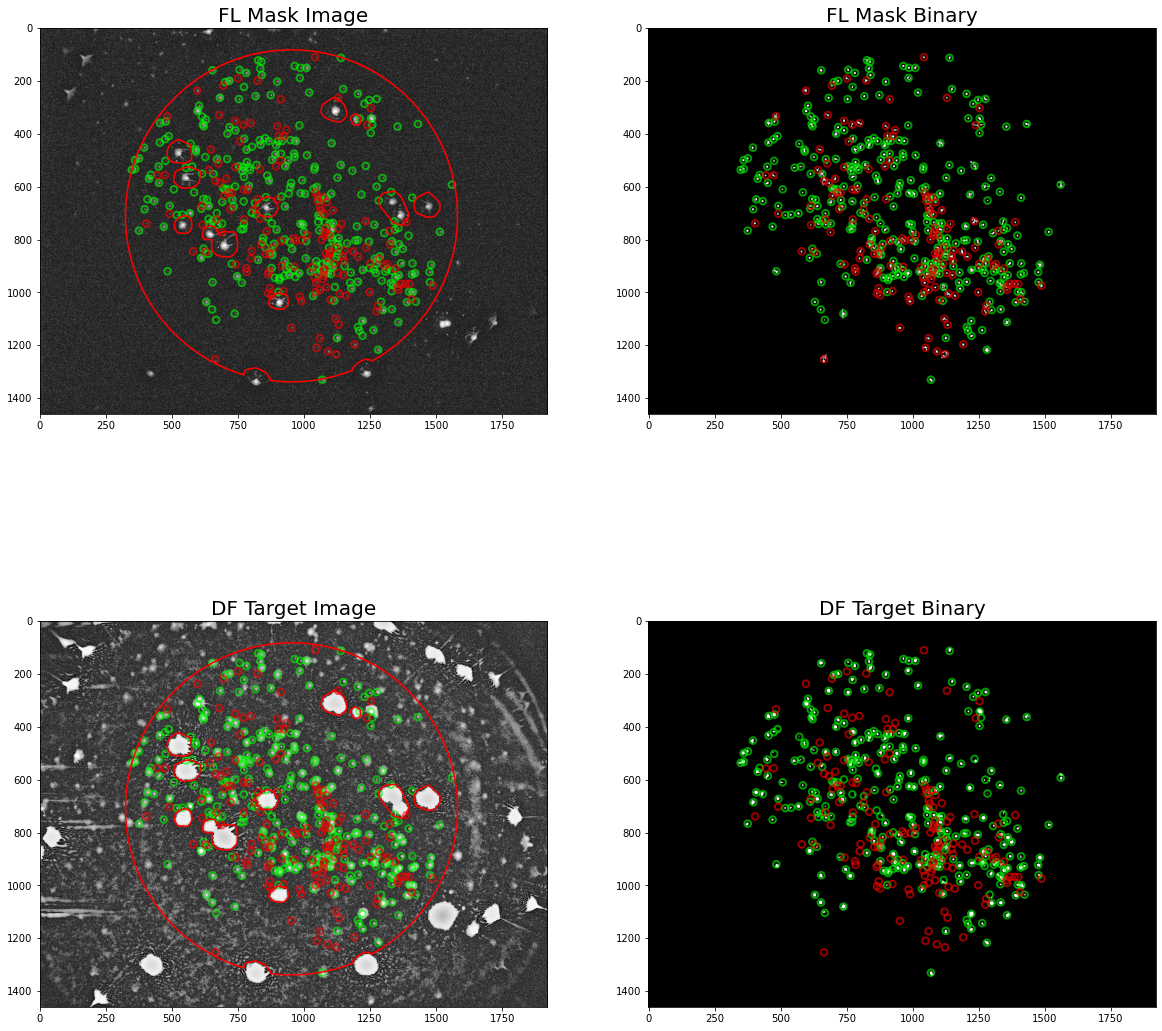

In [6]:
mask_raw = plt.imread("/Users/gallops/Documents/SEDIA_process/Images_for_Caleb/3_11_2021/Exosomes/CD44_AuNP/DF01.tif").astype(float)
detect_radius = dia1.results.target_radius+dia1.results.mask_radius
pos_coords = dia1.data.loc[dia1.data.positive,["mask_coordX","mask_coordY"]].values
neg_coords = dia1.data.loc[~dia1.data.positive,["mask_coordX","mask_coordY"]].values
mask_binary = dia1.mask_label
mask_binary[mask_binary>0]=1
overlap_binary = dia1.overlap_label
overlap_binary[overlap_binary>0]=1

fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(20,20))
axs[0,0].set_title("FL Mask Image",fontsize=20)
axs[0,0].imshow(np.log10(dia1.mask_bgcorr),cmap="gray")
axs[0,0].contour(dia1.mask_defect,[0.5], colors='red')

for coord in pos_coords:
    y,x= coord
    c = plt.Circle((x, y), detect_radius, color='lime', alpha=0.6,linewidth=2, fill=False)
    axs[0,0].add_patch(c)
    
for coord in neg_coords:
    y,x= coord
    c = plt.Circle((x, y), detect_radius, color='red', alpha=0.6,linewidth=2, fill=False)
    axs[0,0].add_patch(c)
    
axs[1,0].set_title("DF Target Image",fontsize=20)
axs[1,0].imshow(np.log10(dia1.target_bgcorr),cmap="gray")
axs[1,0].contour(dia1.mask_defect,[0.5], colors='red')

for coord in pos_coords:
    y,x= coord
    c = plt.Circle((x, y), detect_radius, color='lime', alpha=0.6,linewidth=2, fill=False)
    axs[1,0].add_patch(c)
    
for coord in neg_coords:
    y,x= coord
    c = plt.Circle((x, y), detect_radius, color='red', alpha=0.6,linewidth=2, fill=False)
    axs[1,0].add_patch(c)

axs[0,1].set_title("FL Mask Binary",fontsize=20)
axs[0,1].imshow(mask_binary,cmap="gray")

for coord in pos_coords:
    y,x= coord
    c = plt.Circle((x, y), detect_radius, color='lime', alpha=0.6,linewidth=2, fill=False)
    axs[0,1].add_patch(c)
    
for coord in neg_coords:
    y,x= coord
    c = plt.Circle((x, y), detect_radius, color='red', alpha=0.6,linewidth=2, fill=False)
    axs[0,1].add_patch(c)
    
axs[1,1].set_title("DF Target Binary",fontsize=20)
axs[1,1].imshow(overlap_binary,cmap="gray")

for coord in pos_coords:
    y,x= coord
    c = plt.Circle((x, y), detect_radius, color='lime', alpha=0.6,linewidth=2, fill=False)
    axs[1,1].add_patch(c)
    
for coord in neg_coords:
    y,x= coord
    c = plt.Circle((x, y), detect_radius, color='red', alpha=0.6,linewidth=2, fill=False)
    axs[1,1].add_patch(c)
    

In [ ]:
fig, axs = plt.subplots(figsize=(10,25),nrows=4)

axs[0].set_title("Image 01",fontsize=22)
axs[0].hist(np.log10(dia1.data.biomarker_intensity),density=True,bins="fd",
        color="gold",edgecolor="black",alpha=0.5)
bw = np.gradient(np.histogram(np.log10(dia1.data.biomarker_intensity),bins="fd")[1]).mean()
bot = 0 #np.log10(9)
upp = np.log10(65000*(2.5*dia1.results.target_radius[0])**2)
x = np.linspace(bot,upp,101)
pdf = gaussian_kde(np.log10(dia1.data.biomarker_intensity),bw_method='silverman').evaluate(x)
axs[0].plot(x,pdf,color="black")
axs[0].set_xlabel("Log-Intensity",fontsize=22)
axs[0].set_ylabel("Density",fontsize=22)
axs[0].tick_params(axis='x', labelsize= 20)
axs[0].tick_params(axis='y', labelsize= 20)

axs[1].set_title("Image 02",fontsize=22)
axs[1].hist(np.log10(dia2.data.biomarker_intensity),density=True,bins="fd",
        color="gold",edgecolor="black",alpha=0.5)
bw = np.gradient(np.histogram(np.log10(dia2.data.biomarker_intensity),bins="fd")[1]).mean()
bot = 0 #np.log10(9)
upp = np.log10(65000*(2.5*dia2.results.target_radius[0])**2)
x = np.linspace(bot,upp,101)
pdf = gaussian_kde(np.log10(dia2.data.biomarker_intensity),bw_method='silverman').evaluate(x)
axs[1].plot(x,pdf,color="black")
axs[1].set_xlabel("Log-Intensity",fontsize=22)
axs[1].set_ylabel("Density",fontsize=22)
axs[1].tick_params(axis='x', labelsize= 20)
axs[1].tick_params(axis='y', labelsize= 20)


axs[2].hist(np.log10(dia3.data.biomarker_intensity),density=True,bins="fd",
        color="gold",edgecolor="black",alpha=0.5)
bw = np.gradient(np.histogram(np.log10(dia3.data.biomarker_intensity),bins="fd")[1]).mean()
bot = 0 #np.log10(9)
upp = np.log10(65000*(2.5*dia3.results.target_radius[0])**2)
x = np.linspace(bot,upp,101)
pdf = gaussian_kde(np.log10(dia3.data.biomarker_intensity),bw_method='silverman').evaluate(x)
axs[2].plot(x,pdf,color="black")
axs[2].set_xlabel("Log-Intensity",fontsize=22)
axs[2].set_ylabel("Density",fontsize=22)
axs[2].tick_params(axis='x', labelsize= 20)
axs[2].tick_params(axis='y', labelsize= 20)


axs[3].hist(np.log10(dia4.data.biomarker_intensity),density=True,bins="fd",
        color="gold",edgecolor="black",alpha=0.5)
bw = np.gradient(np.histogram(np.log10(dia4.data.biomarker_intensity),bins="fd")[1]).mean()
bot = 0 #np.log10(9)
upp = 8 #np.log10(65000*(2.5*dia4.results.target_radius[0])**2)
x = np.linspace(bot,upp,101)
pdf = gaussian_kde(np.log10(dia4.data.biomarker_intensity),bw_method='silverman').evaluate(x)
axs[3].plot(x,pdf,color="black")
axs[3].set_xlabel("Log-Intensity",fontsize=22)
axs[3].set_ylabel("Density",fontsize=22)
axs[3].tick_params(axis='x', labelsize= 20)
axs[3].tick_params(axis='y', labelsize= 20)



#plt.savefig("proposal_hist.jpg")

In [7]:
cd44_exos = pd.concat([dia1.data,dia2.data,dia3.data,dia4.data],axis=0)
cd44_exos.to_csv("cd44_exos.csv",index=False)

cd44_results = pd.concat([dia1.results,dia2.results,dia3.results],axis=0)
cd44_results.to_csv("cd44_results.csv",index=True)

In [ ]:
cd44_results

In [ ]:
concat_cd44 = cd44_exos.biomarker_log_intensity.values

fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Image 01",fontsize=22)


ax.hist(concat_cd44,density=True,bins="fd",
        color="gold",edgecolor="black",alpha=0.5)
bw = np.gradient(np.histogram(concat_cd44,bins="fd")[1]).mean()
bot = 0 #np.log10(9)
upp = 8 #np.log10(65000*(2.5*dia1.results.target_radius[0])**2)
x = np.linspace(bot,upp,101)
pdf = gaussian_kde(concat_cd44,bw_method='silverman').evaluate(x)
ax.plot(x,pdf,color="black")
ax.set_xlabel("Log-Intensity",fontsize=22)
ax.set_ylabel("Density",fontsize=22)
ax.tick_params(axis='x', labelsize= 20)
ax.tick_params(axis='y', labelsize= 20)
